# packages and data setting

In [42]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

import numpy as np

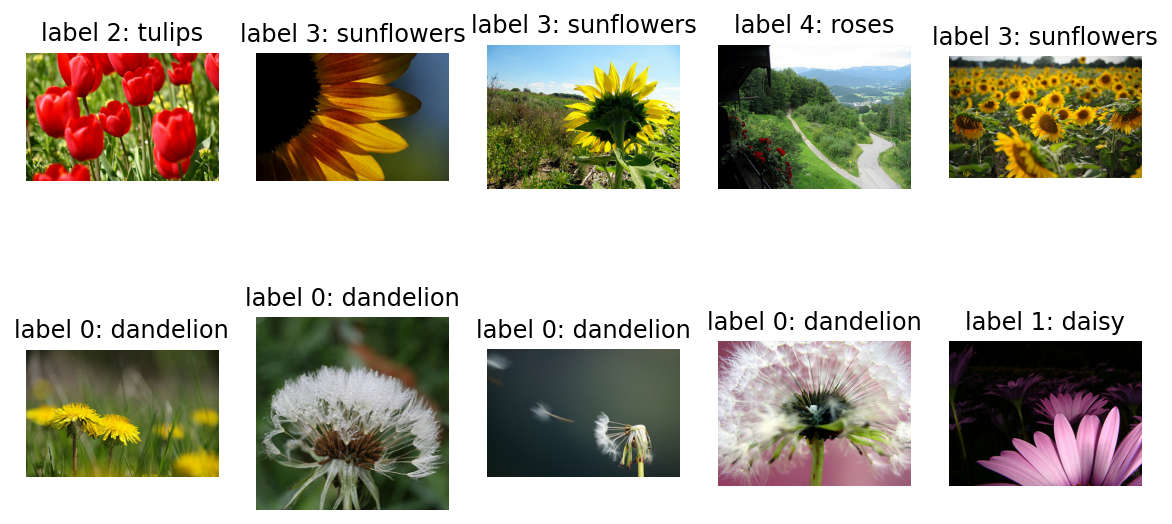

In [43]:

tfds.__version__

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [44]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label


train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)



BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [45]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    #predictions = model.predict(image_batch)
    pass

# VGG setting

In [80]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

image_batch.shape

feature_batch = base_model(image_batch)
feature_batch.shape

base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [81]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

base_model.trainable = False


model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

model.summary()

(32, 512)
(32, 5)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


# Model Training and Evaluation

In [92]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

validation_steps=10
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

EPOCHS = 10

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

10/10 [==============================] - 1s 58ms/step - loss: 0.4475 - accuracy: 0.8438
initial loss: 0.45
initial accuracy: 0.84
Epoch 1/10
92/92 [==============================] - 8s 88ms/step - loss: 0.3439 - accuracy: 0.8879 - val_loss: 0.4471 - val_accuracy: 0.8420
Epoch 2/10
92/92 [==============================] - 8s 83ms/step - loss: 0.3377 - accuracy: 0.8927 - val_loss: 0.4542 - val_accuracy: 0.8311
Epoch 3/10
92/92 [==============================] - 8s 82ms/step - loss: 0.3317 - accuracy: 0.8927 - val_loss: 0.4501 - val_accuracy: 0.8392
Epoch 4/10
92/92 [==============================] - 8s 83ms/step - loss: 0.3293 - accuracy: 0.8924 - val_loss: 0.4432 - val_accuracy: 0.8392
Epoch 5/10
92/92 [==============================] - 8s 84ms/step - loss: 0.3239 - accuracy: 0.8941 - val_loss: 0.4535 - val_accuracy: 0.8256
Epoch 6/10
92/92 [==============================] - 8s 86ms/step - loss: 0.3194 - accuracy: 0.8961 - val_loss: 0.4373 - val_accuracy: 0.8556
Epoch 7/10
92/92 [======

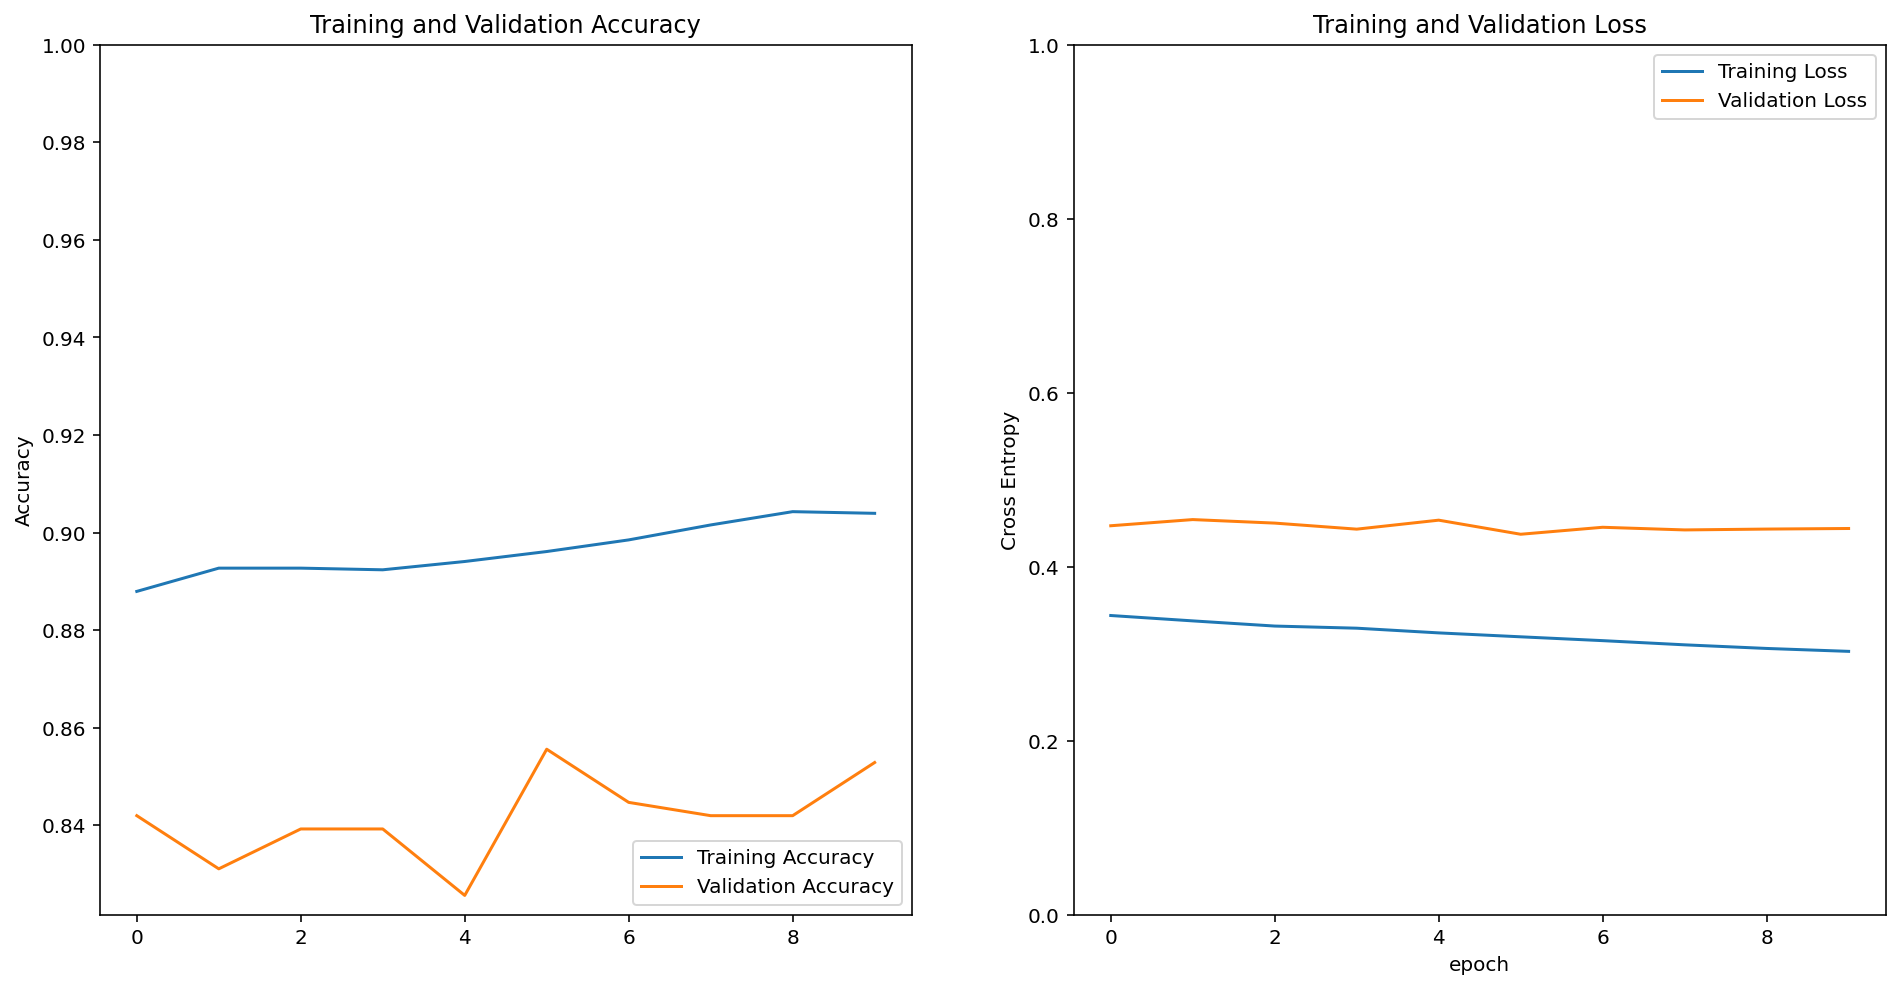

In [93]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



In [94]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions = np.argmax(predictions, axis=1)

count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100) # 약 95% 내외
#VGG16
# 20 epoch : 87
# 10 epoch : 90.625
# 5  epoch : 78.125

#VGG19
# 30 epoch : 84.375
# 20 epoch : 81.25
# 10 epoch : 75.0

90.625


# Save params of model

In [95]:
import os

checkpoint_dir = os.getenv("HOME") + "/aiffel/E4_project/epoch_10/checkpoint"
#경로명은 알아서 잘 설정하세요!!

checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')
    
model.save_weights(checkpoint_file_path)     # checkpoint 파일 생성

if os.path.exists(checkpoint_file_path):
    print('checkpoint 파일 생성 OK!!')

checkpoint 파일 생성 OK!!


# evaluation using other images downloaded from google

In [96]:
img_dir_path = os.getenv("HOME") + "/aiffel/E4_project/images"
#이미지 경로명도 알아서 잘 설정해야합니다!!


os.path.exists(img_dir_path)

from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [125]:
def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    _1_percentage = round(prediction[0] * 100)
    _2_percentage = round(prediction[1] * 100)
    _3_percentage = round(prediction[2] * 100)
    _4_percentage = round(prediction[3] * 100)
    _5_percentage = round(prediction[4] * 100)
    print(f"This image seems {_1_percentage}% dandelion, {_2_percentage}% daisy, {_3_percentage}% tulips, {_4_percentage}% sunflowers, {_5_percentage}% roses.")


This image seems 0.0% dandelion, 0.0% daisy, 0.0% tulips, 0.0% sunflowers, 100.0% roses.


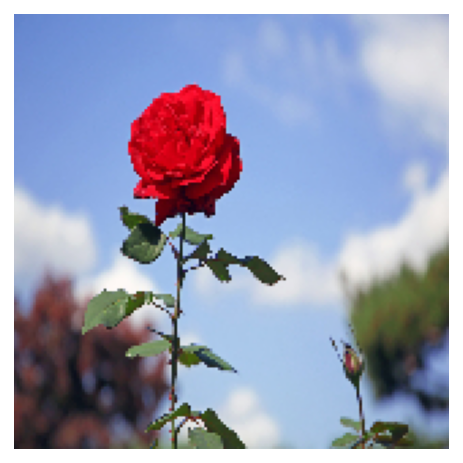

In [127]:
filename = ['rose.jpg', 'daisy.jpg', 'sunflower.jpg', 'dandelion.jpg', 'tulips.jpg']
show_and_predict_image(img_dir_path, filename[0])


This image seems 0.0% dandelion, 100.0% daisy, 0.0% tulips, 0.0% sunflowers, 0.0% roses.


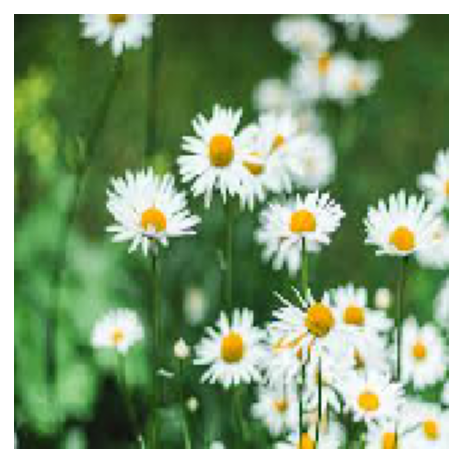

In [128]:
show_and_predict_image(img_dir_path, filename[1])

This image seems 0.0% dandelion, 0.0% daisy, 100.0% tulips, 0.0% sunflowers, 0.0% roses.


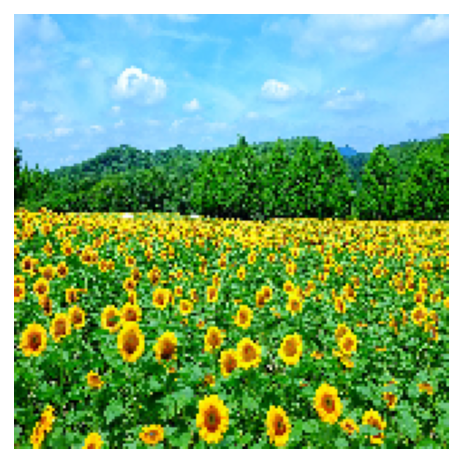

In [129]:
show_and_predict_image(img_dir_path, filename[2])

This image seems 0.0% dandelion, 96.0% daisy, 4.0% tulips, 0.0% sunflowers, 0.0% roses.


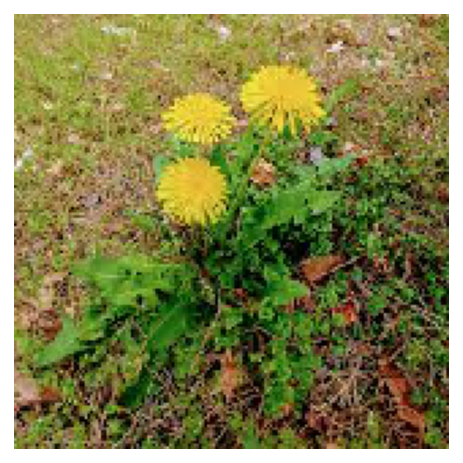

In [130]:
show_and_predict_image(img_dir_path, filename[3])

This image seems 0.0% dandelion, 0.0% daisy, 100.0% tulips, 0.0% sunflowers, 0.0% roses.


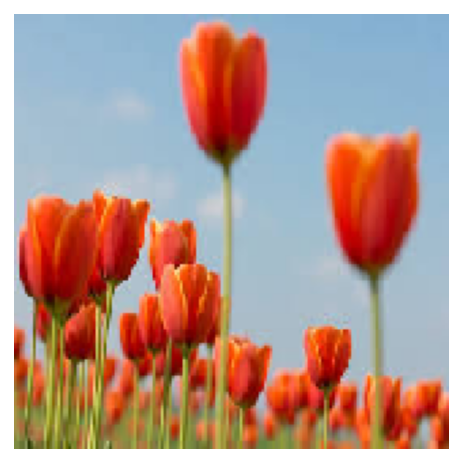

In [131]:
show_and_predict_image(img_dir_path, filename[4])

# Discussion

VGG16과 19 모두 사용해봤는데 16이 성능이 더 잘 나오는 것 같았다.
epoch를 다르게 하며 실험을 해보았다.
값을 늘릴수록 training, validation data에 대한 acc가 상능하길래
epoch를 계속 늘렸는데 test data에 대한 acc는 감소하였다. 
너무 training에 overfit되었던 것 같다.
따라서 적절한 값인 epoch=10으로 설정하고 실험을 진행하였다. 

실험결과는 약 90%으로 준수한 성능을 보여주었다.

인터넷에서 각 클래스별 사진을 받아서 직접 넣어 실험을 해보았다.
90%의 성능이길래 다 맞힐 줄 알았는데... ㅠㅠ